1.   Model: Klasifikasi Biner (Binary Classification)
2.   Algoritma: Random Forest Classifier (Klasifikasi)
3.   Algoritma: Random Forest Regressor (Regresi)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
from tabulate import tabulate
file_path = "/content/Data_Curah_Hujan_Updated.csv"
df = pd.read_csv(file_path, delimiter=";")

df = pd.read_csv(file_path, delimiter=";")

print(tabulate(df, headers='keys', tablefmt='grid'))

+-----+-------+------------+-----------+-----------+-----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|     | Kab   | NamaPos    | Lintang   | Bujur     |   Elevasi |   Tahun |   Bulan |   Tgl 1 |   Tgl 2 |   Tgl 3 |   Tgl 4 |   Tgl 5 |   Tgl 6 |   Tgl 7 |   T

In [ ]:
import pandas as pd

df_long = df.melt(id_vars=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan"],
                  var_name="Hari", value_name="Nilai")

df_long['Tipe'] = df_long['Hari'].apply(lambda x: 'WL' if 'WL' in x else 'Curah Hujan')

df_long['Hari'] = df_long['Hari'].str.extract(r'(\d+)')

df_long['Hari'] = pd.to_numeric(df_long['Hari'], errors='coerce').astype('Int64')
df_long['Tahun'] = pd.to_numeric(df_long['Tahun'], errors='coerce').astype('Int64')
df_long['Bulan'] = pd.to_numeric(df_long['Bulan'], errors='coerce').astype('Int64')

df_long = df_long.dropna(subset=['Hari', 'Tahun', 'Bulan'])

df_curah_hujan = df_long[df_long['Tipe'] == 'Curah Hujan'].rename(columns={"Nilai": "Curah Hujan"}).drop(columns=["Tipe"])
df_wl = df_long[df_long['Tipe'] == 'WL'].rename(columns={"Nilai": "Water Level"}).drop(columns=["Tipe"])

df_final = pd.merge(df_curah_hujan, df_wl, on=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan", "Hari"], how="inner")

# Konversi ke format datetime dengan penanganan error
def safe_date_conversion(row):
    try:
        return pd.Timestamp(year=row['Tahun'], month=row['Bulan'], day=row['Hari'])
    except ValueError:
        return None

df_final['Tanggal'] = df_final.apply(safe_date_conversion, axis=1)

# Hapus baris yang memiliki tanggal tidak valid
df_final = df_final.dropna(subset=['Tanggal'])

# Tampilkan hasil transformasi
print(df_final.head())

     Kab    NamaPos  Lintang      Bujur  Elevasi  Tahun  Bulan  Hari  Curah Hujan  Water Level    Tanggal
0  Bogor  Katulampa  -66,333  1.068.342      361   2011      1     1            0          144 2011-01-01
1  Bogor  Katulampa  -66,333  1.068.342      361   2011      2     1            3          155 2011-02-01
2  Bogor  Katulampa  -66,333  1.068.342      361   2011      3     1            0           91 2011-03-01
3  Bogor  Katulampa  -66,333  1.068.342      361   2011      4     1            3          117 2011-04-01
4  Bogor  Katulampa  -66,333  1.068.342      361   2011      5     1           28          132 2011-05-01


In [ ]:
print(df_final.columns)

Index(['Kab', 'NamaPos', 'Lintang', 'Bujur', 'Elevasi', 'Tahun', 'Bulan',
       'Hari', 'Curah Hujan', 'Water Level'],
      dtype='object')


In [ ]:
# Urutkan data berdasarkan NamaPos dan Tanggal
df_final = df_final.sort_values(by=["NamaPos", "Tanggal"])

# Buat fitur curah hujan rata-rata dalam 3, 7, dan 14 hari terakhir
df_final['CurahHujan_3Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_7Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_14Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

# Buat fitur water level rata-rata dalam 3, 7, dan 14 hari terakhir
df_final['WaterLevel_3Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_7Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_14Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

# Tentukan target banjir (1 jika Water Level > 150, 0 jika tidak)
AMBANG_BANJIR = 150  # Bisa disesuaikan
df_final['Banjir'] = (df_final['Water Level'] > AMBANG_BANJIR).astype(int)

# Tampilkan hasil transformasi
print(df_final.head())

        Kab    NamaPos  Lintang      Bujur  Elevasi  Tahun  Bulan  Hari  Curah Hujan  Water Level    Tanggal  CurahHujan_3Hari  CurahHujan_7Hari  CurahHujan_14Hari  WaterLevel_3Hari  WaterLevel_7Hari  WaterLevel_14Hari  Banjir
0     Bogor  Katulampa  -66,333  1.068.342      361   2011      1     1            0          144 2011-01-01          0.000000          0.000000           0.000000             144.0            144.00             144.00       0
264   Bogor  Katulampa  -66,333  1.068.342      361   2011      1     2            0          197 2011-01-02          0.000000          0.000000           0.000000             170.5            170.50             170.50       1
528   Bogor  Katulampa  -66,333  1.068.342      361   2011      1     3            8          118 2011-01-03          2.666667          2.666667           2.666667             153.0            153.00             153.00       0
792   Bogor  Katulampa  -66,333  1.068.342      361   2011      1     4            3        

In [ ]:
# Pilih fitur untuk model
features = ['CurahHujan_3Hari', 'CurahHujan_7Hari', 'CurahHujan_14Hari',
            'WaterLevel_3Hari', 'WaterLevel_7Hari', 'WaterLevel_14Hari']

X = df_final[features]
y = df_final['Banjir']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Inisialisasi model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Latih model
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Prediksi pada data uji
y_pred = model_rf.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Akurasi Model: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Akurasi Model: 77.43%
Confusion Matrix:
 [[911 173]
 [190 334]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      1084
           1       0.66      0.64      0.65       524

    accuracy                           0.77      1608
   macro avg       0.74      0.74      0.74      1608
weighted avg       0.77      0.77      0.77      1608



Test Model belum tuning

---
Klasifikasi


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

file_path = "/content/Data_Curah_Hujan_Updated.csv"
df = pd.read_csv(file_path, delimiter=";")

df_long = df.melt(id_vars=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan"],
                  var_name="Hari", value_name="Nilai")

df_long['Tipe'] = df_long['Hari'].apply(lambda x: 'WL' if 'WL' in x else 'Curah Hujan')

df_long['Hari'] = df_long['Hari'].str.extract(r'(\d+)')

df_long['Hari'] = pd.to_numeric(df_long['Hari'], errors='coerce').astype('Int64')
df_long['Tahun'] = pd.to_numeric(df_long['Tahun'], errors='coerce').astype('Int64')
df_long['Bulan'] = pd.to_numeric(df_long['Bulan'], errors='coerce').astype('Int64')

df_long = df_long.dropna(subset=['Hari', 'Tahun', 'Bulan'])

df_curah_hujan = df_long[df_long['Tipe'] == 'Curah Hujan'].rename(columns={"Nilai": "Curah Hujan"}).drop(columns=["Tipe"])
df_wl = df_long[df_long['Tipe'] == 'WL'].rename(columns={"Nilai": "Water Level"}).drop(columns=["Tipe"])

# Gabungkan kembali berdasarkan Tahun, Bulan, Hari, dan NamaPos
df_final = pd.merge(df_curah_hujan, df_wl, on=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan", "Hari"], how="inner")

# Konversi ke format datetime dengan penanganan error
def safe_date_conversion(row):
    try:
        return pd.Timestamp(year=row['Tahun'], month=row['Bulan'], day=row['Hari'])
    except ValueError:
        return None  # Jika terjadi error, return NaN

df_final['Tanggal'] = df_final.apply(safe_date_conversion, axis=1)

# Hapus baris yang memiliki tanggal tidak valid
df_final = df_final.dropna(subset=['Tanggal'])

# Tampilkan hasil transformasi
print(df_final.head())

# Pembuatan Fitur Tambahan
df_final = df_final.sort_values(by=["NamaPos", "Tanggal"])  # Urutkan data

# Fitur curah hujan rata-rata
df_final['CurahHujan_3Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_7Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_14Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

# Fitur water level rata-rata
df_final['WaterLevel_3Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_7Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_14Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

# Buat Label Banjir (1 jika Water Level > 150, 0 jika tidak)
AMBANG_BANJIR = 150
df_final['Banjir'] = (df_final['Water Level'] > AMBANG_BANJIR).astype(int)

# Split Data untuk Model
features = ['CurahHujan_3Hari', 'CurahHujan_7Hari', 'CurahHujan_14Hari',
            'WaterLevel_3Hari', 'WaterLevel_7Hari', 'WaterLevel_14Hari']
X = df_final[features]
y = df_final['Banjir']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Latih Model Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Evaluasi Model
y_pred = model_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Akurasi Model: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

     Kab    NamaPos  Lintang      Bujur  Elevasi  Tahun  Bulan  Hari  Curah Hujan  Water Level    Tanggal
0  Bogor  Katulampa  -66,333  1.068.342      361   2011      1     1            0          144 2011-01-01
1  Bogor  Katulampa  -66,333  1.068.342      361   2011      2     1            3          155 2011-02-01
2  Bogor  Katulampa  -66,333  1.068.342      361   2011      3     1            0           91 2011-03-01
3  Bogor  Katulampa  -66,333  1.068.342      361   2011      4     1            3          117 2011-04-01
4  Bogor  Katulampa  -66,333  1.068.342      361   2011      5     1           28          132 2011-05-01
Akurasi Model: 77.43%
Confusion Matrix:
 [[911 173]
 [190 334]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      1084
           1       0.66      0.64      0.65       524

    accuracy                           0.77      1608
   macro avg       0.74      0.74      0.74      1608
weig

Test Model di Tuning (RandomizedSearchCV)

---
Klasifikasi

---
**Finish**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

file_path = "/content/Data_Curah_Hujan_Updated.csv"
df = pd.read_csv(file_path, delimiter=";")

df_long = df.melt(id_vars=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan"],
                  var_name="Hari", value_name="Nilai")

df_long['Tipe'] = df_long['Hari'].apply(lambda x: 'WL' if 'WL' in x else 'Curah Hujan')

df_long['Hari'] = df_long['Hari'].str.extract(r'(\d+)')
df_long['Hari'] = pd.to_numeric(df_long['Hari'], errors='coerce').astype('Int64')
df_long['Tahun'] = pd.to_numeric(df_long['Tahun'], errors='coerce').astype('Int64')
df_long['Bulan'] = pd.to_numeric(df_long['Bulan'], errors='coerce').astype('Int64')

df_long = df_long.dropna(subset=['Hari', 'Tahun', 'Bulan'])

df_curah_hujan = df_long[df_long['Tipe'] == 'Curah Hujan'].rename(columns={"Nilai": "Curah Hujan"}).drop(columns=["Tipe"])
df_wl = df_long[df_long['Tipe'] == 'WL'].rename(columns={"Nilai": "Water Level"}).drop(columns=["Tipe"])

df_final = pd.merge(df_curah_hujan, df_wl, on=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan", "Hari"], how="inner")

def safe_date_conversion(row):
    try:
        return pd.Timestamp(year=row['Tahun'], month=row['Bulan'], day=row['Hari'])
    except ValueError:
        return None

df_final['Tanggal'] = df_final.apply(safe_date_conversion, axis=1)
df_final = df_final.dropna(subset=['Tanggal'])

# Pembuatan fitur tambahan
df_final = df_final.sort_values(by=["NamaPos", "Tanggal"])
df_final['CurahHujan_3Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_7Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_14Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

df_final['WaterLevel_3Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_7Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_14Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

# Buat label banjir
AMBANG_BANJIR = 150
df_final['Banjir'] = (df_final['Water Level'] > AMBANG_BANJIR).astype(int)

# Split Data
features = ['CurahHujan_3Hari', 'CurahHujan_7Hari', 'CurahHujan_14Hari',
            'WaterLevel_3Hari', 'WaterLevel_7Hari', 'WaterLevel_14Hari']
X = df_final[features]
y = df_final['Banjir']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter tuning dengan RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    verbose=2,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

# Model terbaik berdasarkan tuning
best_params = rf_random.best_params_
print("Best Parameters:", best_params)

# Latih ulang model dengan parameter terbaik
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Evaluasi Model
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Akurasi Model: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20}
Akurasi Model: 79.17%
Confusion Matrix:
 [[926 158]
 [177 347]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      1084
           1       0.69      0.66      0.67       524

    accuracy                           0.79      1608
   macro avg       0.76      0.76      0.76      1608
weighted avg       0.79      0.79      0.79      1608



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Prediksi pada training dan testing set
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

#Evaluasi pada Training Data
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

#Evaluasi pada Testing Data
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print("\n**Evaluasi Model pada Training Data:**")
print(f"MAE (Training): {mae_train:.2f} mm")
print(f"RMSE (Training): {rmse_train:.2f} mm")
print(f"R² Score (Training): {r2_train * 100:.2f}%")

print("\n**Evaluasi Model pada Testing Data:**")
print(f"MAE (Testing): {mae_test:.2f} mm")
print(f"RMSE (Testing): {rmse_test:.2f} mm")
print(f"R² Score (Testing): {r2_test * 100:.2f}%")


**Evaluasi Model pada Training Data:**
MAE (Training): 0.07 mm
RMSE (Training): 0.26 mm
R² Score (Training): 68.22%

**Evaluasi Model pada Testing Data:**
MAE (Testing): 0.21 mm
RMSE (Testing): 0.46 mm
R² Score (Testing): 5.16%


Test Model - Regresi

---

(RandomizedSearchCV)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

file_path = "/content/Data_Curah_Hujan_Updated.csv"
df = pd.read_csv(file_path, delimiter=";")

df_long = df.melt(id_vars=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan"],
                  var_name="Hari", value_name="Nilai")

#Pisahkan antara Curah Hujan dan Water Level
df_long['Tipe'] = df_long['Hari'].apply(lambda x: 'WL' if 'WL' in x else 'Curah Hujan')
df_long['Hari'] = df_long['Hari'].str.extract(r'(\d+)')
df_long['Hari'] = pd.to_numeric(df_long['Hari'], errors='coerce').astype('Int64')
df_long['Tahun'] = pd.to_numeric(df_long['Tahun'], errors='coerce').astype('Int64')
df_long['Bulan'] = pd.to_numeric(df_long['Bulan'], errors='coerce').astype('Int64')

df_long = df_long.dropna(subset=['Hari', 'Tahun', 'Bulan'])

#Pisahkan menjadi dua dataframe
df_curah_hujan = df_long[df_long['Tipe'] == 'Curah Hujan'].rename(columns={"Nilai": "Curah Hujan"}).drop(columns=["Tipe"])
df_wl = df_long[df_long['Tipe'] == 'WL'].rename(columns={"Nilai": "Water Level"}).drop(columns=["Tipe"])

#Gabungkan kembali
df_final = pd.merge(df_curah_hujan, df_wl, on=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan", "Hari"], how="inner")

def safe_date_conversion(row):
    try:
        return pd.Timestamp(year=row['Tahun'], month=row['Bulan'], day=row['Hari'])
    except ValueError:
        return None

df_final['Tanggal'] = df_final.apply(safe_date_conversion, axis=1)
df_final = df_final.dropna(subset=['Tanggal'])

# Pembuatan fitur tambahan
df_final = df_final.sort_values(by=["NamaPos", "Tanggal"])
df_final['CurahHujan_3Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_7Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_14Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

df_final['WaterLevel_3Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_7Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_14Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

# Target: Prediksi Water Level
X = df_final[['CurahHujan_3Hari', 'CurahHujan_7Hari', 'CurahHujan_14Hari', 'WaterLevel_3Hari', 'WaterLevel_7Hari', 'WaterLevel_14Hari']]
y = df_final['Water Level']  # Target regresi

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning dengan RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    verbose=2,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

# Model terbaik berdasarkan tuning
best_params = rf_random.best_params_
print("Best Parameters:", best_params)

# Latih ulang model dengan parameter terbaik
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Prediksi pada Training & Testing Data
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Evaluasi Model
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

# Konversi Prediksi Water Level menjadi Klasifikasi Banjir
AMBANG_BANJIR = 150
y_test_class = (y_test > AMBANG_BANJIR).astype(int)
y_pred_class = (y_test_pred > AMBANG_BANJIR).astype(int)

# Evaluasi Klasifikasi
accuracy = accuracy_score(y_test_class, y_pred_class)
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
class_report = classification_report(y_test_class, y_pred_class)

print("\n**Evaluasi Model pada Training Data:**")
print(f"MAE (Training): {mae_train:.2f} mm")
print(f"RMSE (Training): {rmse_train:.2f} mm")
print(f"R² Score (Training): {r2_train * 100:.2f}%")

print("\n**Evaluasi Model pada Testing Data:**")
print(f"MAE (Testing): {mae_test:.2f} mm")
print(f"RMSE (Testing): {rmse_test:.2f} mm")
print(f"R² Score (Testing): {r2_test * 100:.2f}%")

print(f"\nAkurasi Model: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}

**Evaluasi Model pada Training Data:**
MAE (Training): 19.26 mm
RMSE (Training): 25.10 mm
R² Score (Training): 81.03%

**Evaluasi Model pada Testing Data:**
MAE (Testing): 22.29 mm
RMSE (Testing): 29.16 mm
R² Score (Testing): 72.91%

Akurasi Model: 78.73%
Confusion Matrix:
 [[922 159]
 [183 344]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      1081
           1       0.68      0.65      0.67       527

    accuracy                           0.79      1608
   macro avg       0.76      0.75      0.76      1608
weighted avg       0.79      0.79      0.79      1608



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

file_path = "/content/Data_Curah_Hujan_Updated.csv"
df = pd.read_csv(file_path, delimiter=";")

df_long = df.melt(id_vars=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan"],
                  var_name="Hari", value_name="Nilai")

# Pisahkan antara Curah Hujan dan Water Level
df_long['Tipe'] = df_long['Hari'].apply(lambda x: 'WL' if 'WL' in x else 'Curah Hujan')
df_long['Hari'] = df_long['Hari'].str.extract(r'(\d+)')
df_long['Hari'] = pd.to_numeric(df_long['Hari'], errors='coerce').astype('Int64')
df_long['Tahun'] = pd.to_numeric(df_long['Tahun'], errors='coerce').astype('Int64')
df_long['Bulan'] = pd.to_numeric(df_long['Bulan'], errors='coerce').astype('Int64')

df_long = df_long.dropna(subset=['Hari', 'Tahun', 'Bulan'])

# Pisahkan menjadi dua dataframe
df_curah_hujan = df_long[df_long['Tipe'] == 'Curah Hujan'].rename(columns={"Nilai": "Curah Hujan"}).drop(columns=["Tipe"])
df_wl = df_long[df_long['Tipe'] == 'WL'].rename(columns={"Nilai": "Water Level"}).drop(columns=["Tipe"])

# Gabungkan kembali
df_final = pd.merge(df_curah_hujan, df_wl, on=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan", "Hari"], how="inner")

def safe_date_conversion(row):
    try:
        return pd.Timestamp(year=row['Tahun'], month=row['Bulan'], day=row['Hari'])
    except ValueError:
        return None

df_final['Tanggal'] = df_final.apply(safe_date_conversion, axis=1)
df_final = df_final.dropna(subset=['Tanggal'])

# Pembuatan fitur tambahan
df_final = df_final.sort_values(by=["NamaPos", "Tanggal"])
df_final['CurahHujan_3Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_7Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_14Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

df_final['WaterLevel_3Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_7Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_14Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

# Target: Prediksi Water Level
X = df_final[['CurahHujan_3Hari', 'CurahHujan_7Hari', 'CurahHujan_14Hari', 'WaterLevel_3Hari', 'WaterLevel_7Hari', 'WaterLevel_14Hari']]
y = df_final['Water Level']  # Target regresi

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning dengan RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    verbose=2,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

# Model terbaik berdasarkan tuning
best_params = rf_random.best_params_
print("Best Parameters:", best_params)

# Latih ulang model dengan parameter terbaik
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Prediksi pada Training & Testing Data
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Evaluasi Model
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

# Tampilkan hasil evaluasi
print("\n**Evaluasi Model pada Training Data:**")
print(f"MAE (Training): {mae_train:.2f} mm")
print(f"RMSE (Training): {rmse_train:.2f} mm")
print(f"R² Score (Training): {r2_train * 100:.2f}%")
print(f"MAPE (Training): {mape_train:.2f}%")

print("\n**Evaluasi Model pada Testing Data:**")
print(f"MAE (Testing): {mae_test:.2f} mm")
print(f"RMSE (Testing): {rmse_test:.2f} mm")
print(f"R² Score (Testing): {r2_test * 100:.2f}%")
print(f"MAPE (Testing): {mape_test:.2f}%")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}

**Evaluasi Model pada Training Data:**
MAE (Training): 19.26 mm
RMSE (Training): 25.20 mm
R² Score (Training): 80.88%
MAPE (Training): inf%

**Evaluasi Model pada Testing Data:**
MAE (Testing): 22.32 mm
RMSE (Testing): 29.13 mm
R² Score (Testing): 72.97%
MAPE (Testing): inf%


Fix Mape

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

file_path = "/content/Data_Curah_Hujan_Updated.csv"
df = pd.read_csv(file_path, delimiter=";")

df_long = df.melt(id_vars=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan"],
                  var_name="Hari", value_name="Nilai")

# Pisahkan antara Curah Hujan dan Water Level
df_long['Tipe'] = df_long['Hari'].apply(lambda x: 'WL' if 'WL' in x else 'Curah Hujan')
df_long['Hari'] = df_long['Hari'].str.extract(r'(\d+)')
df_long['Hari'] = pd.to_numeric(df_long['Hari'], errors='coerce').astype('Int64')
df_long['Tahun'] = pd.to_numeric(df_long['Tahun'], errors='coerce').astype('Int64')
df_long['Bulan'] = pd.to_numeric(df_long['Bulan'], errors='coerce').astype('Int64')

df_long = df_long.dropna(subset=['Hari', 'Tahun', 'Bulan'])

# Pisahkan menjadi dua dataframe
df_curah_hujan = df_long[df_long['Tipe'] == 'Curah Hujan'].rename(columns={"Nilai": "Curah Hujan"}).drop(columns=["Tipe"])
df_wl = df_long[df_long['Tipe'] == 'WL'].rename(columns={"Nilai": "Water Level"}).drop(columns=["Tipe"])

# Gabungkan kembali
df_final = pd.merge(df_curah_hujan, df_wl, on=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan", "Hari"], how="inner")

def safe_date_conversion(row):
    try:
        return pd.Timestamp(year=row['Tahun'], month=row['Bulan'], day=row['Hari'])
    except ValueError:
        return None

df_final['Tanggal'] = df_final.apply(safe_date_conversion, axis=1)
df_final = df_final.dropna(subset=['Tanggal'])

# Pembuatan fitur tambahan
df_final = df_final.sort_values(by=["NamaPos", "Tanggal"])
df_final['CurahHujan_3Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_7Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_14Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

df_final['WaterLevel_3Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_7Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_14Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

# Target: Prediksi Water Level
X = df_final[['CurahHujan_3Hari', 'CurahHujan_7Hari', 'CurahHujan_14Hari', 'WaterLevel_3Hari', 'WaterLevel_7Hari', 'WaterLevel_14Hari']]
y = df_final['Water Level']  # Target regresi

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning dengan RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    verbose=2,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

# Model terbaik berdasarkan tuning
best_params = rf_random.best_params_
print("Best Parameters:", best_params)

# Latih ulang model dengan parameter terbaik
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Prediksi pada Training & Testing Data
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Evaluasi Model
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10  # Hindari pembagian dengan nol
    y_true_safe = np.where(y_true == 0, epsilon, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

# Evaluasi Model
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

# Tampilkan hasil evaluasi
print("\n**Evaluasi Model pada Training Data:**")
print(f"MAE (Training): {mae_train:.2f} mm")
print(f"RMSE (Training): {rmse_train:.2f} mm")
print(f"R² Score (Training): {r2_train * 100:.2f}%")
print(f"MAPE (Training): {mape_train:.2f}%")

print("\n**Evaluasi Model pada Testing Data:**")
print(f"MAE (Testing): {mae_test:.2f} mm")
print(f"RMSE (Testing): {rmse_test:.2f} mm")
print(f"R² Score (Testing): {r2_test * 100:.2f}%")
print(f"MAPE (Testing): {mape_test:.2f}%")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}

**Evaluasi Model pada Training Data:**
MAE (Training): 19.24 mm
RMSE (Training): 25.18 mm
R² Score (Training): 80.91%
MAPE (Training): 50164062720.34%

**Evaluasi Model pada Testing Data:**
MAE (Testing): 22.30 mm
RMSE (Testing): 29.13 mm
R² Score (Testing): 72.97%
MAPE (Testing): 4057388398.15%


Model Regresi

---

**Dipakai**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix

file_path = "/content/Data_Curah_Hujan_Updated.csv"
df = pd.read_csv(file_path, delimiter=";")

df_long = df.melt(id_vars=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan"],
                  var_name="Hari", value_name="Nilai")

# Pisahkan antara Curah Hujan dan Water Level
df_long['Tipe'] = df_long['Hari'].apply(lambda x: 'WL' if 'WL' in x else 'Curah Hujan')
df_long['Hari'] = df_long['Hari'].str.extract(r'(\d+)')
df_long['Hari'] = pd.to_numeric(df_long['Hari'], errors='coerce').astype('Int64')
df_long['Tahun'] = pd.to_numeric(df_long['Tahun'], errors='coerce').astype('Int64')
df_long['Bulan'] = pd.to_numeric(df_long['Bulan'], errors='coerce').astype('Int64')

df_long = df_long.dropna(subset=['Hari', 'Tahun', 'Bulan'])

# Pisahkan menjadi dua dataframe
df_curah_hujan = df_long[df_long['Tipe'] == 'Curah Hujan'].rename(columns={"Nilai": "Curah Hujan"}).drop(columns=["Tipe"])
df_wl = df_long[df_long['Tipe'] == 'WL'].rename(columns={"Nilai": "Water Level"}).drop(columns=["Tipe"])

# Gabungkan kembali
df_final = pd.merge(df_curah_hujan, df_wl, on=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan", "Hari"], how="inner")

def safe_date_conversion(row):
    try:
        return pd.Timestamp(year=row['Tahun'], month=row['Bulan'], day=row['Hari'])
    except ValueError:
        return None

df_final['Tanggal'] = df_final.apply(safe_date_conversion, axis=1)
df_final = df_final.dropna(subset=['Tanggal'])

# Pembuatan fitur tambahan
df_final = df_final.sort_values(by=["NamaPos", "Tanggal"])
df_final['CurahHujan_3Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_7Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_14Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

df_final['WaterLevel_3Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_7Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_14Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

# Target: Prediksi Water Level
X = df_final[['CurahHujan_3Hari', 'CurahHujan_7Hari', 'CurahHujan_14Hari', 'WaterLevel_3Hari', 'WaterLevel_7Hari', 'WaterLevel_14Hari']]
y = df_final['Water Level']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning dengan RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    verbose=2,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

# Model terbaik berdasarkan tuning
best_params = rf_random.best_params_
print("Best Parameters:", best_params)

# Latih ulang model dengan parameter terbaik
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Prediksi pada Training & Testing Data
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Evaluasi Model
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

# Perbaikan MAPE: Hindari Pembagian dengan Nol
epsilon = 1e-5
y_train_safe = np.where(y_train == 0, epsilon, y_train)
y_test_safe = np.where(y_test == 0, epsilon, y_test)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_train = mean_absolute_percentage_error(y_train_safe, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test_safe, y_test_pred)

# Alternatif: Median Absolute Percentage Error (MdAPE)
def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

mdape_train = median_absolute_percentage_error(y_train_safe, y_train_pred)
mdape_test = median_absolute_percentage_error(y_test_safe, y_test_pred)

# Tampilkan hasil evaluasi
print("\n**Evaluasi Model pada Training Data:**")
print(f"MAE (Training): {mae_train:.2f} mm")
print(f"RMSE (Training): {rmse_train:.2f} mm")
print(f"R² Score (Training): {r2_train * 100:.2f}%")
print(f"MAPE (Training): {mape_train:.2f}%")
print(f"MdAPE (Training): {mdape_train:.2f}%")

print("\n**Evaluasi Model pada Testing Data:**")
print(f"MAE (Testing): {mae_test:.2f} mm")
print(f"RMSE (Testing): {rmse_test:.2f} mm")
print(f"R² Score (Testing): {r2_test * 100:.2f}%")
print(f"MAPE (Testing): {mape_test:.2f}%")
print(f"MdAPE (Testing): {mdape_test:.2f}%")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}

**Evaluasi Model pada Training Data:**
MAE (Training): 19.25 mm
RMSE (Training): 25.19 mm
R² Score (Training): 80.89%
MAPE (Training): 502862.57%
MdAPE (Training): 14.57%

**Evaluasi Model pada Testing Data:**
MAE (Testing): 22.31 mm
RMSE (Testing): 29.14 mm
R² Score (Testing): 72.95%
MAPE (Testing): 41294.07%
MdAPE (Testing): 15.76%


**Test tambah akurasi**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# Load data
file_path = "/content/Data_Curah_Hujan_Updated.csv"
df = pd.read_csv(file_path, delimiter=";")

# Reshape dan pisahkan data CH & WL
df_long = df.melt(id_vars=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan"],
                  var_name="Hari", value_name="Nilai")

df_long['Tipe'] = df_long['Hari'].apply(lambda x: 'WL' if 'WL' in x else 'Curah Hujan')
df_long['Hari'] = df_long['Hari'].str.extract(r'(\d+)')
df_long['Hari'] = pd.to_numeric(df_long['Hari'], errors='coerce').astype('Int64')
df_long['Tahun'] = pd.to_numeric(df_long['Tahun'], errors='coerce').astype('Int64')
df_long['Bulan'] = pd.to_numeric(df_long['Bulan'], errors='coerce').astype('Int64')
df_long = df_long.dropna(subset=['Hari', 'Tahun', 'Bulan'])

df_curah_hujan = df_long[df_long['Tipe'] == 'Curah Hujan'].rename(columns={"Nilai": "Curah Hujan"}).drop(columns=["Tipe"])
df_wl = df_long[df_long['Tipe'] == 'WL'].rename(columns={"Nilai": "Water Level"}).drop(columns=["Tipe"])

df_final = pd.merge(df_curah_hujan, df_wl, on=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan", "Hari"], how="inner")

# Buat tanggal valid
def safe_date_conversion(row):
    try:
        return pd.Timestamp(year=row['Tahun'], month=row['Bulan'], day=row['Hari'])
    except ValueError:
        return None

df_final['Tanggal'] = df_final.apply(safe_date_conversion, axis=1)
df_final = df_final.dropna(subset=['Tanggal'])
df_final = df_final.sort_values(by=["NamaPos", "Tanggal"])

# Fitur rolling & statistik
df_final['CurahHujan_3Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_7Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(7, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_14Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(14, min_periods=1).mean().reset_index(0, drop=True)

df_final['WaterLevel_3Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_7Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(7, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_14Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(14, min_periods=1).mean().reset_index(0, drop=True)

# Fitur tambahan baru
df_final['Selisih_CurahHujan'] = df_final.groupby("NamaPos")['Curah Hujan'].diff()
df_final['Max_WaterLevel_7Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(7, min_periods=1).max().reset_index(0, drop=True)
df_final['Bulan'] = df_final['Tanggal'].dt.month

# Label banjir
AMBANG_BANJIR = 150
df_final['Banjir'] = (df_final['Water Level'] > AMBANG_BANJIR).astype(int)

# Drop NaN setelah diff
df_final = df_final.dropna(subset=[
    'CurahHujan_3Hari', 'CurahHujan_7Hari', 'CurahHujan_14Hari',
    'WaterLevel_3Hari', 'WaterLevel_7Hari', 'WaterLevel_14Hari',
    'Selisih_CurahHujan', 'Max_WaterLevel_7Hari'
])

# Fitur dan label
features = [
    'CurahHujan_3Hari', 'CurahHujan_7Hari', 'CurahHujan_14Hari',
    'WaterLevel_3Hari', 'WaterLevel_7Hari', 'WaterLevel_14Hari',
    'Selisih_CurahHujan', 'Max_WaterLevel_7Hari', 'Bulan'
]
X = df_final[features]
y = df_final['Banjir']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Oversampling dengan SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=25,
    cv=5,
    verbose=1,
    n_jobs=-1
)
rf_random.fit(X_train_resampled, y_train_resampled)

# Model terbaik
best_params = rf_random.best_params_
print("Best Parameters:", best_params)

best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_resampled, y_train_resampled)

# Evaluasi
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\n🎯 Akurasi Model: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}

🎯 Akurasi Model: 77.29%
Confusion Matrix:
 [[852 231]
 [134 390]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      1083
           1       0.63      0.74      0.68       524

    accuracy                           0.77      1607
   macro avg       0.75      0.77      0.75      1607
weighted avg       0.79      0.77      0.78      1607



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load data
file_path = "Data_Curah_Hujan_Updated.csv"
df = pd.read_csv(file_path, delimiter=";")

# Transformasi ke bentuk long
df_long = df.melt(id_vars=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan"],
                  var_name="Hari", value_name="Nilai")

df_long['Tipe'] = df_long['Hari'].apply(lambda x: 'WL' if 'WL' in x else 'Curah Hujan')
df_long['Hari'] = df_long['Hari'].str.extract(r'(\d+)')
df_long['Hari'] = pd.to_numeric(df_long['Hari'], errors='coerce').astype('Int64')
df_long['Tahun'] = pd.to_numeric(df_long['Tahun'], errors='coerce').astype('Int64')
df_long['Bulan'] = pd.to_numeric(df_long['Bulan'], errors='coerce').astype('Int64')

df_long = df_long.dropna(subset=['Hari', 'Tahun', 'Bulan'])

# Pisahkan curah hujan dan water level
df_curah_hujan = df_long[df_long['Tipe'] == 'Curah Hujan'].rename(columns={"Nilai": "Curah Hujan"}).drop(columns=["Tipe"])
df_wl = df_long[df_long['Tipe'] == 'WL'].rename(columns={"Nilai": "Water Level"}).drop(columns=["Tipe"])

# Gabungkan
df_final = pd.merge(df_curah_hujan, df_wl, on=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan", "Hari"], how="inner")

# Konversi tanggal
def safe_date_conversion(row):
    try:
        return pd.Timestamp(year=row['Tahun'], month=row['Bulan'], day=row['Hari'])
    except ValueError:
        return None

df_final['Tanggal'] = df_final.apply(safe_date_conversion, axis=1)
df_final = df_final.dropna(subset=['Tanggal'])

# Sort dan feature rolling
df_final = df_final.sort_values(by=["NamaPos", "Tanggal"])
df_final['CurahHujan_3Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_7Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_14Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

df_final['WaterLevel_3Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_7Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_14Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

# Label banjir
AMBANG_BANJIR = 150
df_final['Banjir'] = (df_final['Water Level'] > AMBANG_BANJIR).astype(int)

# Fitur dan label
features = ['CurahHujan_3Hari', 'CurahHujan_7Hari', 'CurahHujan_14Hari',
            'WaterLevel_3Hari', 'WaterLevel_7Hari', 'WaterLevel_14Hari']
X = df_final[features]
y = df_final['Banjir']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Tanpa SMOTE, langsung pakai data asli
X_train_resampled, y_train_resampled = X_train, y_train

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train_resampled, y_train_resampled)

# Model terbaik
best_params = rf_random.best_params_
print("Best Parameters:", best_params)

best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_resampled, y_train_resampled)

# Evaluasi model
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\nAkurasi Model: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load data
file_path = "Data_Curah_Hujan_Updated.csv"
df = pd.read_csv(file_path, delimiter=";")

# Transformasi ke bentuk long
df_long = df.melt(id_vars=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan"],
                  var_name="Hari", value_name="Nilai")

df_long['Tipe'] = df_long['Hari'].apply(lambda x: 'WL' if 'WL' in x else 'Curah Hujan')
df_long['Hari'] = df_long['Hari'].str.extract(r'(\d+)')
df_long['Hari'] = pd.to_numeric(df_long['Hari'], errors='coerce').astype('Int64')
df_long['Tahun'] = pd.to_numeric(df_long['Tahun'], errors='coerce').astype('Int64')
df_long['Bulan'] = pd.to_numeric(df_long['Bulan'], errors='coerce').astype('Int64')

df_long = df_long.dropna(subset=['Hari', 'Tahun', 'Bulan'])

# Pisahkan curah hujan dan water level
df_curah_hujan = df_long[df_long['Tipe'] == 'Curah Hujan'].rename(columns={"Nilai": "Curah Hujan"}).drop(columns=["Tipe"])
df_wl = df_long[df_long['Tipe'] == 'WL'].rename(columns={"Nilai": "Water Level"}).drop(columns=["Tipe"])

# Gabungkan
df_final = pd.merge(df_curah_hujan, df_wl, on=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan", "Hari"], how="inner")

# Konversi tanggal
def safe_date_conversion(row):
    try:
        return pd.Timestamp(year=row['Tahun'], month=row['Bulan'], day=row['Hari'])
    except ValueError:
        return None

df_final['Tanggal'] = df_final.apply(safe_date_conversion, axis=1)
df_final = df_final.dropna(subset=['Tanggal'])

# Sort dan feature rolling
df_final = df_final.sort_values(by=["NamaPos", "Tanggal"])
df_final['CurahHujan_3Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_7Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_14Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

df_final['WaterLevel_3Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_7Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_14Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

# Label banjir
AMBANG_BANJIR = 150
df_final['Banjir'] = (df_final['Water Level'] > AMBANG_BANJIR).astype(int)

# Fitur dan label
features = ['CurahHujan_3Hari', 'CurahHujan_7Hari', 'CurahHujan_14Hari',
            'WaterLevel_3Hari', 'WaterLevel_7Hari', 'WaterLevel_14Hari']
X = df_final[features]
y = df_final['Banjir']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Tanpa SMOTE, langsung pakai data asli
X_train_resampled, y_train_resampled = X_train, y_train

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train_resampled, y_train_resampled)

# Model terbaik
best_params = rf_random.best_params_
print("Best Parameters:", best_params)

best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_resampled, y_train_resampled)

# Evaluasi model
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
9
print(f"\nAkurasi Model: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20}

Akurasi Model: 79.17%
Confusion Matrix:
 [[926 158]
 [177 347]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      1084
           1       0.69      0.66      0.67       524

    accuracy                           0.79      1608
   macro avg       0.76      0.76      0.76      1608
weighted avg       0.79      0.79      0.79      1608

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20}

Akurasi Model: 79.17%
Confusion Matrix:
 [[926 158]
 [177 347]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      1084
        

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

# Load data
file_path = "Data_Curah_Hujan_Updated.csv"
df = pd.read_csv(file_path, delimiter=";")

# Transform ke long format
df_long = df.melt(id_vars=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan"],
                  var_name="Hari", value_name="Nilai")
df_long['Tipe'] = df_long['Hari'].apply(lambda x: 'WL' if 'WL' in x else 'Curah Hujan')
df_long['Hari'] = df_long['Hari'].str.extract(r'(\d+)')
df_long['Hari'] = pd.to_numeric(df_long['Hari'], errors='coerce').astype('Int64')
df_long['Tahun'] = pd.to_numeric(df_long['Tahun'], errors='coerce').astype('Int64')
df_long['Bulan'] = pd.to_numeric(df_long['Bulan'], errors='coerce').astype('Int64')
df_long = df_long.dropna(subset=['Hari', 'Tahun', 'Bulan'])

# Pisah curah hujan dan water level
df_curah_hujan = df_long[df_long['Tipe'] == 'Curah Hujan'].rename(columns={"Nilai": "Curah Hujan"}).drop(columns=["Tipe"])
df_wl = df_long[df_long['Tipe'] == 'WL'].rename(columns={"Nilai": "Water Level"}).drop(columns=["Tipe"])

# Merge
df_final = pd.merge(df_curah_hujan, df_wl, on=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan", "Hari"], how="inner")

# Konversi tanggal
def safe_date_conversion(row):
    try:
        return pd.Timestamp(year=row['Tahun'], month=row['Bulan'], day=row['Hari'])
    except ValueError:
        return None

df_final['Tanggal'] = df_final.apply(safe_date_conversion, axis=1)
df_final = df_final.dropna(subset=['Tanggal'])

# Feature rolling rata-rata
df_final = df_final.sort_values(by=["NamaPos", "Tanggal"])
df_final['CurahHujan_3Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_7Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['CurahHujan_14Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

df_final['WaterLevel_3Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_7Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df_final['WaterLevel_14Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

# Label
AMBANG_BANJIR = 150
df_final['Banjir'] = (df_final['Water Level'] > AMBANG_BANJIR).astype(int)

# === Tambahkan Fitur Ekstra ===
df_final['Elevasi'] = pd.to_numeric(df_final['Elevasi'], errors='coerce')
df_final = df_final.dropna(subset=['Elevasi'])

# One-hot encode Kabupaten dan Bulan
df_encoded = pd.get_dummies(df_final[['Kab', 'Bulan']], drop_first=True)

# Gabungkan semua fitur
X = pd.concat([
    df_final[['CurahHujan_3Hari', 'CurahHujan_7Hari', 'CurahHujan_14Hari',
              'WaterLevel_3Hari', 'WaterLevel_7Hari', 'WaterLevel_14Hari',
              'Elevasi']],
    df_encoded
], axis=1)

y = df_final['Banjir']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train, y_train)
best_params = rf_random.best_params_
print("Best Parameters:", best_params)

# Train final model
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Evaluasi
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\n Akurasi Model: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}

✅ Akurasi Model: 80.29%
Confusion Matrix:
 [[939 145]
 [172 352]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1084
           1       0.71      0.67      0.69       524

    accuracy                           0.80      1608
   macro avg       0.78      0.77      0.77      1608
weighted avg       0.80      0.80      0.80      1608



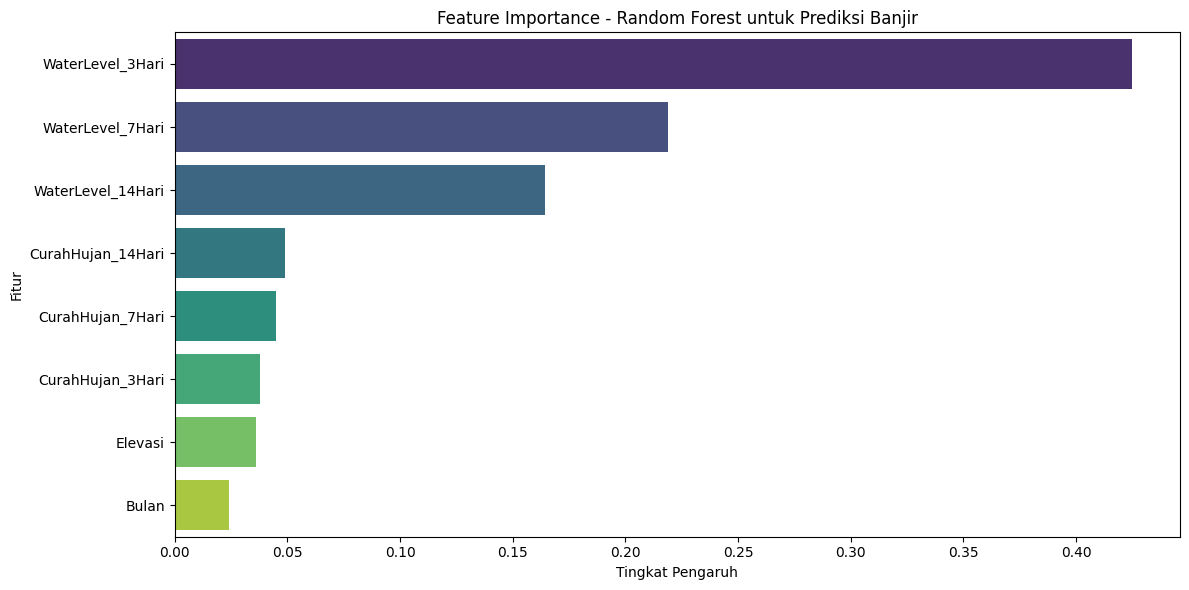

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil nilai importance
importances = best_rf.feature_importances_
feature_names = X.columns

# Buat DataFrame untuk visualisasi
feat_imp_df = pd.DataFrame({
    'Fitur': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualisasi
plt.figure(figsize=(12, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Fitur', palette='viridis')
plt.title('Feature Importance - Random Forest untuk Prediksi Banjir')
plt.xlabel('Tingkat Pengaruh')
plt.ylabel('Fitur')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# BACA DATA
file_path = "/content/Data_Curah_Hujan_Updated.csv"
df = pd.read_csv(file_path, delimiter=";")

# TRANSFORMASI LONG FORMAT
df_long = df.melt(id_vars=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan"],
                  var_name="Hari", value_name="Nilai")

# TENTUKAN TIPE
df_long['Tipe'] = df_long['Hari'].apply(lambda x: 'WL' if 'WL' in x else 'Curah Hujan')
df_long['Hari'] = df_long['Hari'].str.extract(r'(\d+)')

# KONVERSI KE NUMERIC & HANDLE NaN
df_long['Tahun'] = pd.to_numeric(df_long['Tahun'], errors='coerce')
df_long['Bulan'] = pd.to_numeric(df_long['Bulan'], errors='coerce')
df_long['Hari'] = pd.to_numeric(df_long['Hari'], errors='coerce')
df_long = df_long.dropna(subset=['Tahun', 'Bulan', 'Hari'])

# KONVERSI KE INT64
df_long['Tahun'] = df_long['Tahun'].astype('Int64')
df_long['Bulan'] = df_long['Bulan'].astype('Int64')
df_long['Hari'] = df_long['Hari'].astype('Int64')

# PISAHKAN CURAH HUJAN DAN WL
df_curah_hujan = df_long[df_long['Tipe'] == 'Curah Hujan'].rename(columns={"Nilai": "Curah Hujan"}).drop(columns=["Tipe"])
df_wl = df_long[df_long['Tipe'] == 'WL'].rename(columns={"Nilai": "Water Level"}).drop(columns=["Tipe"])

# MERGE
df_final = pd.merge(df_curah_hujan, df_wl,
                    on=["Kab", "NamaPos", "Lintang", "Bujur", "Elevasi", "Tahun", "Bulan", "Hari"],
                    how="inner")

# TANGGAL
def safe_date_conversion(row):
    try:
        return pd.Timestamp(year=int(row['Tahun']), month=int(row['Bulan']), day=int(row['Hari']))
    except Exception:
        return None

df_final['Tanggal'] = df_final.apply(safe_date_conversion, axis=1)
df_final = df_final.dropna(subset=['Tanggal'])

# FITUR ROLLING
df_final = df_final.sort_values(by=["NamaPos", "Tanggal"])
for window in [3, 7, 14]:
    df_final[f'CurahHujan_{window}Hari'] = df_final.groupby("NamaPos")['Curah Hujan'].rolling(window=window, min_periods=1).mean().reset_index(0, drop=True)
    df_final[f'WaterLevel_{window}Hari'] = df_final.groupby("NamaPos")['Water Level'].rolling(window=window, min_periods=1).mean().reset_index(0, drop=True)

# LABEL BANJIR
AMBANG_BANJIR = 150
df_final['Banjir'] = (df_final['Water Level'] > AMBANG_BANJIR).astype(int)

# FITUR & LABEL
features = [col for col in df_final.columns if 'CurahHujan' in col or 'WaterLevel' in col]
X = df_final[features]
y = df_final['Banjir']

# SCALING FITUR
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# RANDOM FOREST + HYPERPARAMETER TUNING
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(rf, param_distributions=param_grid,
                               n_iter=30, cv=5, verbose=1,
                               n_jobs=-1, random_state=42)
rf_random.fit(X_train, y_train)

# TRAIN FINAL MODEL
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)

# EVALUASI
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# HASIL
print("Best Parameters:", rf_random.best_params_)
print(f"Akurasi Model: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}
Akurasi Model: 80.10%
Confusion Matrix:
 [[933 151]
 [169 355]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85      1084
           1       0.70      0.68      0.69       524

    accuracy                           0.80      1608
   macro avg       0.77      0.77      0.77      1608
weighted avg       0.80      0.80      0.80      1608

